# DavidNet and One Cycle Policy

In this assignment we had to train a network (similar to [DavidNet](https://github.com/davidcpage/cifar10-fast/tree/d31ad8d393dd75147b65f261dbf78670a97e48a8)) to upto 90% accuracy in 24 epochs, using one cycle lr policy.

In [1]:
# installing the athena package
! pip install git+https://github.com/firekind/athena > /dev/null

  Running command git clone -q https://github.com/firekind/athena /tmp/pip-req-build-x7665a5x


## Importing and setup

In [27]:
from athena.tuning.lr_finder import LRFinder
from athena import datasets, Experiment, Experiments, ClassificationSolver
from athena.models import DavidNet
from athena.utils.transforms import ToNumpy, ToTensor
from athena.visualizations import plot_experiments, gradcam_misclassified, plot_misclassified

import torch.nn.functional as F
import torch.optim as optim
import albumentations as A
import cv2
import matplotlib.pyplot as plt

### Creating the dataloaders

In [2]:
train_loader = (
    datasets.cifar10()
    .batch_size(512)
    .train()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.Normalize(mean=datasets.cifar10.mean, std=datasets.cifar10.std, max_pixel_value=1.0),
        A.PadIfNeeded(40, 40, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomCrop(32, 32),
        A.HorizontalFlip(),
        A.Cutout(num_holes=1),
        A.Lambda(ToTensor),
    ]))
    .build()
)

test_loader = (
    datasets.cifar10()
    .batch_size(512)
    .test()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.Normalize(mean=datasets.cifar10.mean, std=datasets.cifar10.std, max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

Files already downloaded and verified
Files already downloaded and verified


### Creating a model and running the lr range test on it.

In [4]:
model = DavidNet()
criterion = F.cross_entropy
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
def acc_fn(outputs, labels):
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.eq(labels.view_as(pred)).float()
    return correct.mean()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.32E-03


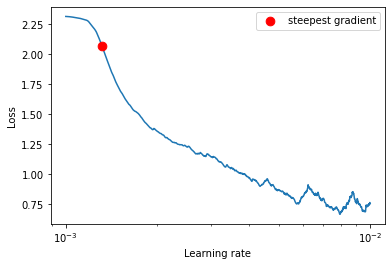

best lr (where loss is least): 0.007945945945945946


In [5]:
lr_finder = LRFinder(model, optimizer, criterion, acc_fn=acc_fn, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1e-2, num_iter=1000, step_mode="linear")
res = lr_finder.plot(skip_start=0, skip_end=0)

## Experimenting
For the first set of experiments, the max lr was taken as the lr where the loss was least during the range test, instead of the steepest slope. Reason being that at the point where the slope is the steepest, the loss is pretty high.

To find the most optimal lr, 3 experiments were run.

1. max lr=0.00794
2. max lr=1e-2
3. max lr=2e-2

In [15]:
epochs = 24
exp1 = (
    Experiments.builder()
    .name("DavidNet")
    .log_directory("./drive/My Drive/EVA5/logs")
    .add("max_lr=0.00794")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=0.00794, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=0.00794, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .add("max_lr=1e-2")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=1e-2, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=1e-2, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs)
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .add("max_lr=2e-2")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=2e-2, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=2e-2, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs)
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .build()
)

In [16]:
exp1.run()

=> Running experiment: max_lr=0.00794
Epoch: 1 / 24
98/98 [==============================] - 16s 167ms/step - train loss: 1.6950 - train accuracy: 42.0980
Test set: Average loss: 1.2355, Accuracy: 5619/10000 (56.19%)

Epoch: 2 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 1.1562 - train accuracy: 59.5660
Test set: Average loss: 1.0471, Accuracy: 6484/10000 (64.84%)

Epoch: 3 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 0.9640 - train accuracy: 66.3760
Test set: Average loss: 1.1251, Accuracy: 6394/10000 (63.94%)

Epoch: 4 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 0.8890 - train accuracy: 69.9440
Test set: Average loss: 0.9606, Accuracy: 6890/10000 (68.90%)

Epoch: 5 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 0.8365 - train accuracy: 72.2100
Test set: Average loss: 0.7051, Accuracy: 7686/10000 (76.86%)

Epoch: 6 / 24
98/98 [==============================] - 16s 167

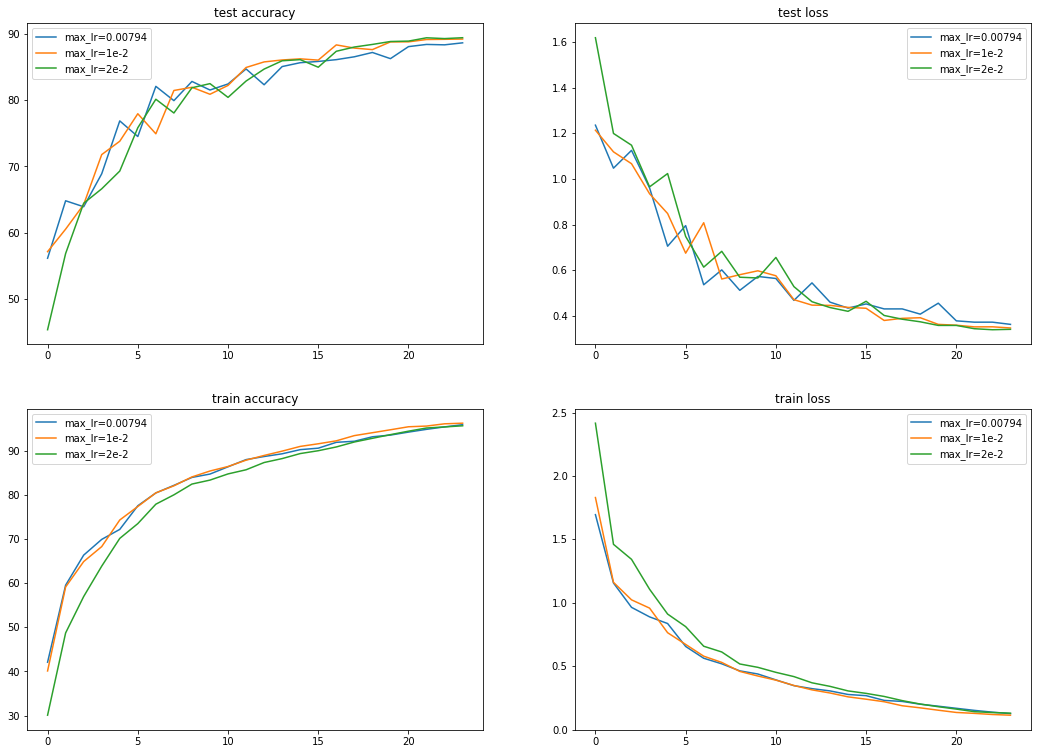

In [22]:
plot_experiments(exp1)

Summarizing the results:

1. The experiment with the max lr as 0.00794, 
    1. there was certainly a big jump in accuracy at epoch 5 (when the lr was maximum)
    2. max accuracy that was reached was 88.61%
2. The experiment with the max lr as 1e-2,
    1. Again, we see a jump in accuracy at epoch 5
    2. max accuracy that was reached was 89.19%. Looks like increasing the lr is the way to go.
3. The experiment with the max lr as 2e-2,
    1. Not such a drastic jump in accuracy at epoch 5 like the previous experiments, but a jump nonetheless.
    2. max accuracy that was reached was 89.38%. We are getting there!

### Second set of experiments

For the second set of experiments, we still increase the lr.

1. For the first experiment, the lr was kept to be 2.5e-2
2. For the second experiment, the lr was kept to be 3e-2

In [17]:
epochs = 24
exp2 = (
    Experiments.builder()
    .name("DavidNet")
    .log_directory("./drive/My Drive/EVA5/logs")
    .add("max_lr=2.5e-2")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=2.5e-2, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=2.5e-2, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .add("max_lr=3e-2")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=3e-2, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=3e-2, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs)
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .build()
)

In [18]:
exp2.run()

=> Running experiment: max_lr=2.5e-2
Epoch: 1 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 2.3641 - train accuracy: 33.0820
Test set: Average loss: 1.4902, Accuracy: 4486/10000 (44.86%)

Epoch: 2 / 24
98/98 [==============================] - 16s 164ms/step - train loss: 1.4040 - train accuracy: 50.6840
Test set: Average loss: 1.1878, Accuracy: 5844/10000 (58.44%)

Epoch: 3 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 1.0845 - train accuracy: 62.4700
Test set: Average loss: 0.9793, Accuracy: 6705/10000 (67.05%)

Epoch: 4 / 24
98/98 [==============================] - 16s 165ms/step - train loss: 0.9529 - train accuracy: 68.5080
Test set: Average loss: 1.1295, Accuracy: 6501/10000 (65.01%)

Epoch: 5 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 0.8329 - train accuracy: 72.5480
Test set: Average loss: 0.7501, Accuracy: 7612/10000 (76.12%)

Epoch: 6 / 24
98/98 [==============================] - 16s 166m

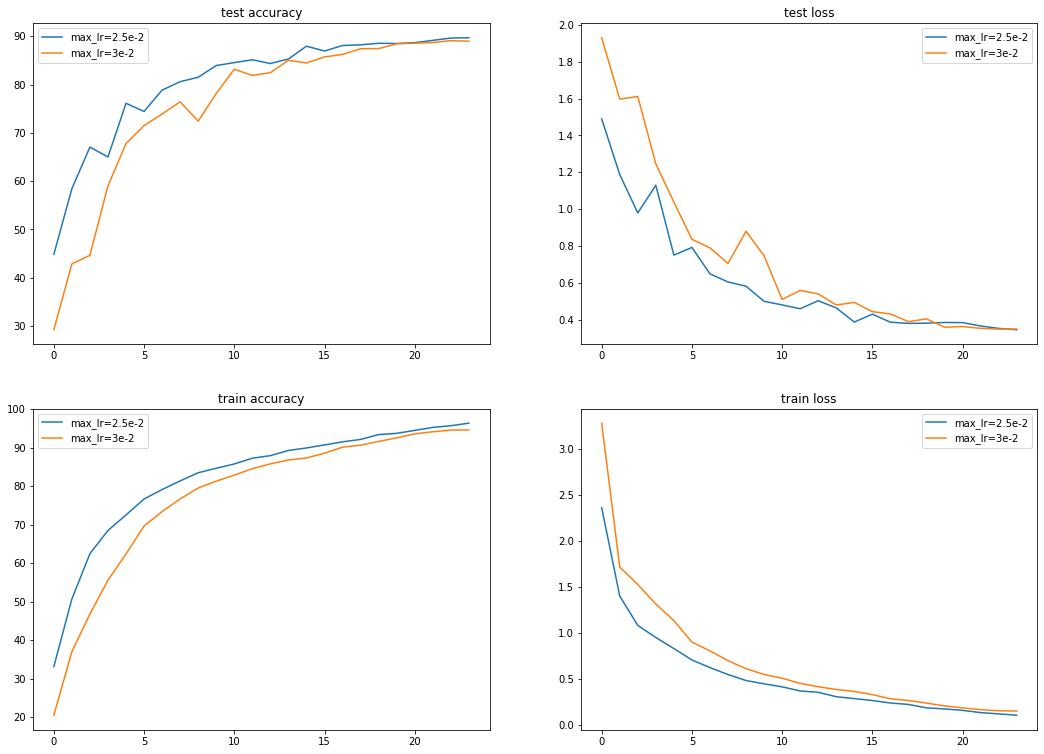

In [23]:
plot_experiments(exp2)

Summarizing the results:

1. The experiment with the max lr as 2.5e-2, 
    1. there was certainly a big jump in accuracy at epoch 5 (when the lr was maximum)
    2. max accuracy that was reached was 89.69%, very close to the desired accuracy
2. The experiment with the max lr as 3e-2,
    1. Again, we see a jump in accuracy at epoch 5
    2. max accuracy dropped to 89.08%. Looks like increasing beyond 3e-2 is not a good idea.


### Third set of experiments
This time we run two experiments,

1. with lr=2.25e-2
2. with lr=2.75e-2

In [19]:
epochs = 24
exp3 = (
    Experiments.builder()
    .name("DavidNet")
    .log_directory("./drive/My Drive/EVA5/logs")
    .add("max_lr=2.25e-2")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=2.25e-2, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=2.25e-2, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs, anneal_strategy="linear")
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .add("max_lr=2.75e-2")
        .model(DavidNet())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=2.75e-2, momentum=0.9)
            .scheduler(optim.lr_scheduler.OneCycleLR, max_lr=2.75e-2, div_factor=8, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=5/epochs)
            .epochs(epochs)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device("cuda")
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .build()
)

In [20]:
exp3.run()

=> Running experiment: max_lr=2.25e-2
Epoch: 1 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 2.2996 - train accuracy: 33.0960
Test set: Average loss: 1.6648, Accuracy: 4497/10000 (44.97%)

Epoch: 2 / 24
98/98 [==============================] - 16s 165ms/step - train loss: 1.4643 - train accuracy: 50.8760
Test set: Average loss: 1.2253, Accuracy: 5654/10000 (56.54%)

Epoch: 3 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 1.1282 - train accuracy: 61.9920
Test set: Average loss: 1.2654, Accuracy: 6347/10000 (63.47%)

Epoch: 4 / 24
98/98 [==============================] - 16s 165ms/step - train loss: 0.9931 - train accuracy: 67.1980
Test set: Average loss: 0.8916, Accuracy: 6859/10000 (68.59%)

Epoch: 5 / 24
98/98 [==============================] - 16s 166ms/step - train loss: 0.8107 - train accuracy: 72.9480
Test set: Average loss: 0.7593, Accuracy: 7369/10000 (73.69%)

Epoch: 6 / 24
98/98 [==============================] - 16s 165

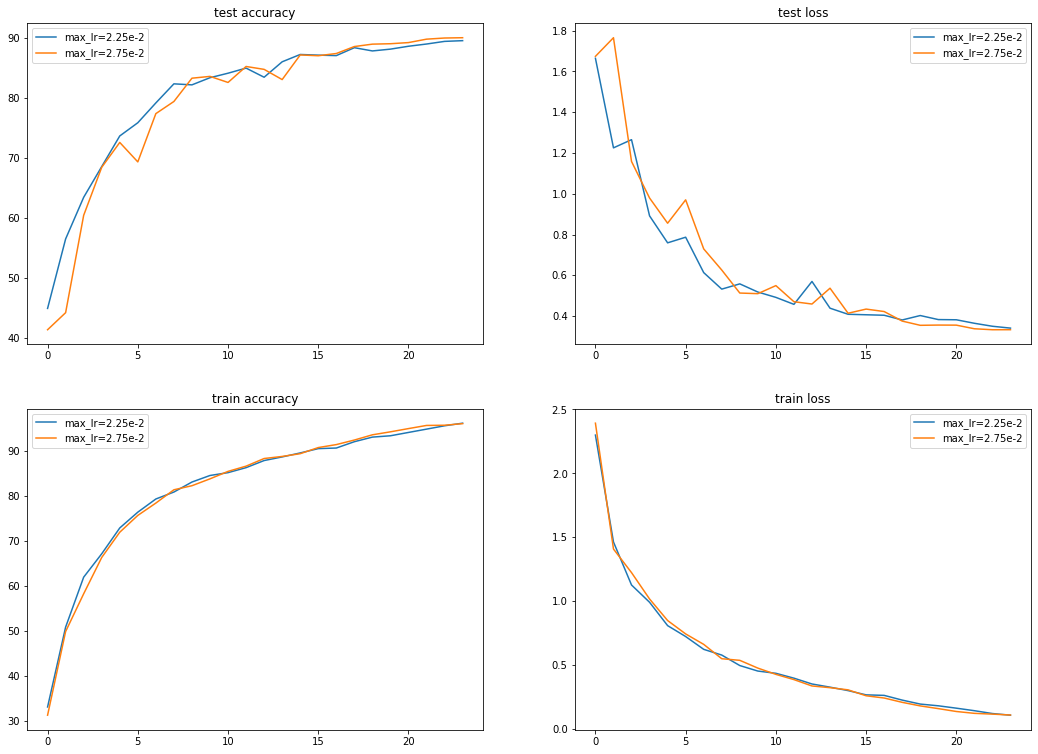

In [24]:
plot_experiments(exp3)

Summarizing the results:

1. The experiment with the max lr as 2.25e-2, 
    1. there was certainly a big jump in accuracy at epoch 5 (when the lr was maximum)
    2. max accuracy that was reached was 89.56%, looks like the desired lr is between 2.5e-2 and 3e-2
2. The experiment with the max lr as 2.75e-2,
    1. Again, we see a jump in accuracy at epoch 5
    2. max accuracy reached is 90.05%! Bingo!

## Visualizations

Plotting some of the misclassified images by the best experiment:

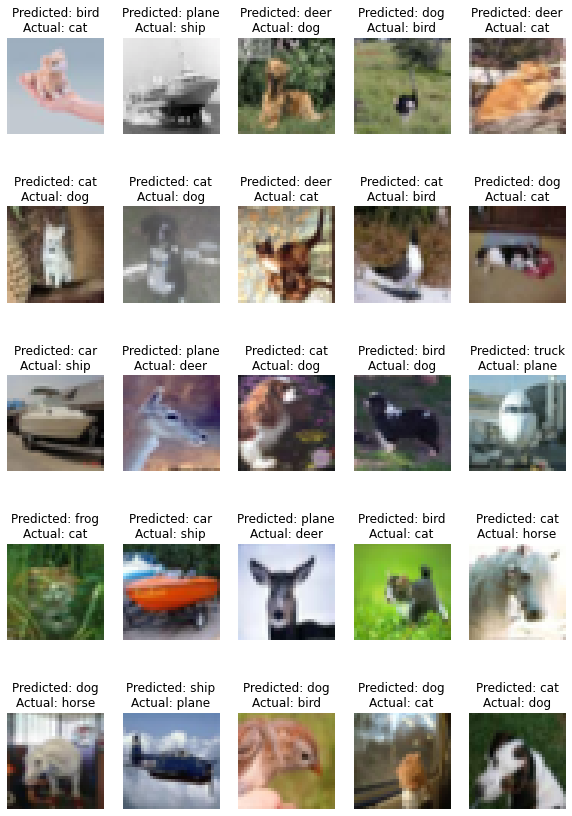

In [28]:
plot_misclassified(
    25,
    exp3["max_lr=2.75e-2"],
    test_loader,
    "cuda",
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=datasets.cifar10.mean,
    std=datasets.cifar10.std
)

And the gradcam for the misclassified images:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


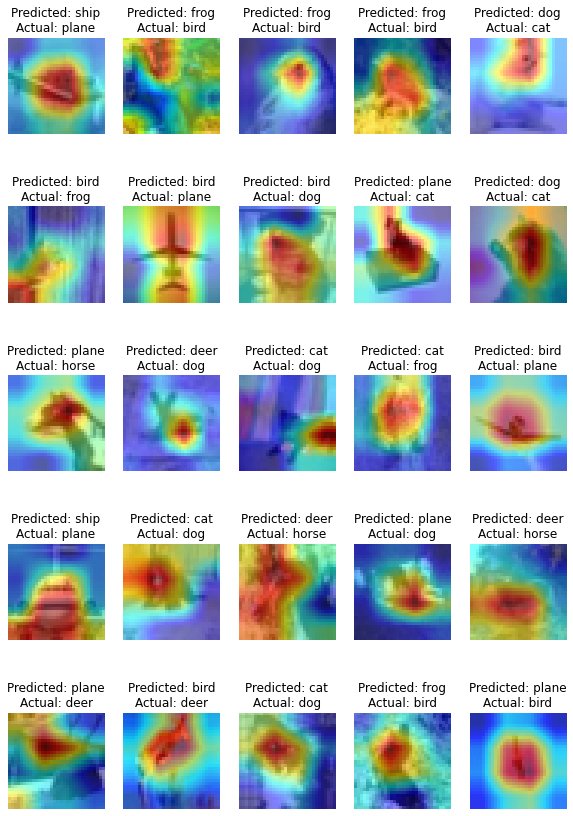

In [29]:
gradcam_misclassified(
    25,
    exp3["max_lr=2.75e-2"],
    exp3["max_lr=2.75e-2"].model.layer3,
    test_loader,
    "cuda",
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=datasets.cifar10.mean,
    std=datasets.cifar10.std,
)